## VQE with Qiskit Aer Primitives

This notebook will show how to use Qiskit Aer Primitives to run both noiseless and noisy simulations locally. Qiskit Aer not only allows you to define your own custom noise model, but also to easily create a noise model based on properties of a real quantum device. 

In [1]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


In [2]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver


numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(H2_op)
ref_value = result.eigenvalue.real

# reference value 
print(f'ref value: {ref_value}')

ref value: -1.857275030202382


In [3]:
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA 

iterations = 125
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks = 'cz')
spsa = SPSA(maxiter = iterations)

#### No Noise

Let's first run VQE on a default Aer simulator without noise, with a fixed seed for the run and transpilation to obtain reproducible results. This result should be relatively close to the reference. 

In [4]:
# define callback 

counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std): 
    counts.append(eval_count)
    values.append(mean)

In [5]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator 

seed = 170 
algorithm_globals.random_seed = seed 

noiseless_estimator = AerEstimator( 
    run_options = {'seed': seed, 'shots': 1024}, 
    transpile_options = {'seed_transpiler': seed}
)

In [7]:
from qiskit_algorithms.minimum_eigensolvers import VQE 

vqe = VQE(noiseless_estimator, ansatz, optimizer = spsa, callback = store_intermediate_result)

result = vqe.compute_minimum_eigenvalue(operator = H2_op)

print('VQE on AER QASM simulator (no noise) ', result.eigenvalue.real)
print('Delta from reference energy value is ', abs(result.eigenvalue.real - ref_value))

VQE on AER QASM simulator (no noise)  -1.8509688396039292
Delta from reference energy value is  0.006306190598452721


Text(0.5, 1.0, 'Convergence with no noise')

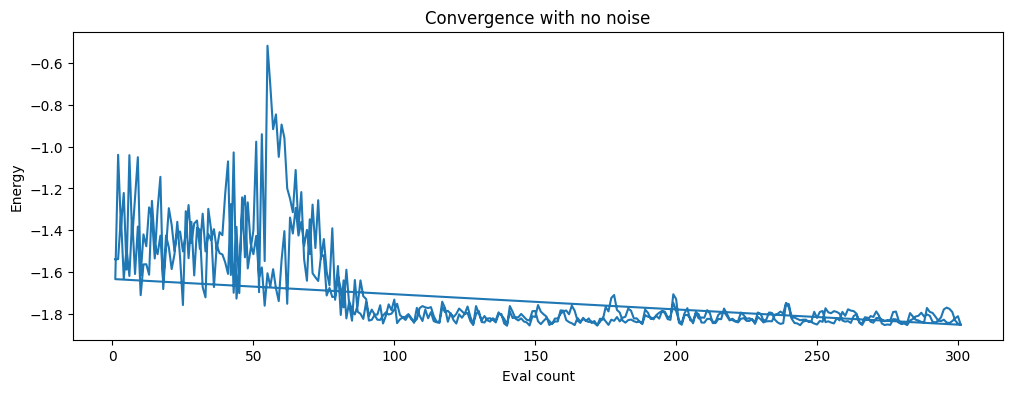

In [10]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

## With Noise

Now let's add noise to the simulation. We will extract noise model from a fake device.  

Let's get an actual device backend from its `configuration` and `properties`. We can setup a coupling map and a noise model to match the device. We can also use this coupling map as the entanglement map for the variational form if we choose to. 

In [13]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import Fake5QV1


device = Fake5QV1()

coupling_map = device.configuration().coupling_map 
noise_model = NoiseModel.from_backend(device)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'cx', 'sx', 'id', 'measure', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 2)), ('cx', (2, 4)), ('cx', (3, 2)), ('cx', (2, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 2)), ('cx', (2, 0)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (3, 4)), ('cx', (4, 3)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


Now we can run the VQE using the Estimator, where we can pass the noise model to the underlying simulator using `backend_options`. This simulation will take longer. 

In [15]:
noisy_estimator = AerEstimator( 
    backend_options = {
        'method': 'density_matrix', 
        'coupling_map': coupling_map, 
        'noise_model': noise_model
    }, 
    run_options = {'seed': seed, 'shots': 1024}, 
    transpile_options = {'seed_transpiler': seed}
)

In [16]:
# restart callback variables
counts = []
values = [] 

vqe.estimator = noisy_estimator

result_noise = vqe.compute_minimum_eigenvalue(operator = H2_op)

print(f"VQE on Aer Simulator (with noise): {result_noise.eigenvalue.real}")
print(f"Delta from reference energy: {abs(result_noise.eigenvalue.real - ref_value)}")

VQE on Aer Simulator (with noise): -1.7286354819375036
Delta from reference energy: 0.12863954826487833


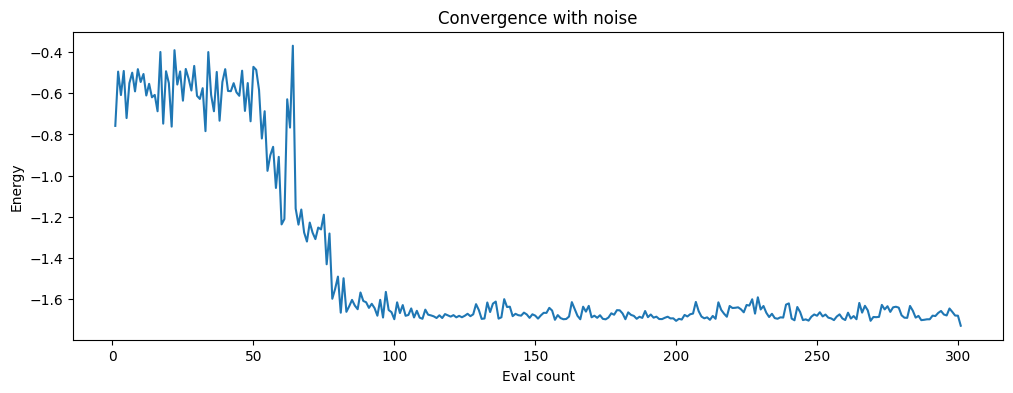

In [17]:
if counts or values:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise")

## Summary

We compared three calculations for the H2 molecule ground state. First we produced a reference value using a classical minimum eigensolver. Then we ran a VQE using an `Estimator` with 1024 shots. Finally, we extracted a noise model from a backend and used it to define a new `Estimator` for noisy simulations. The results are: 

In [20]:
print(f"Reference value: {ref_value:.5f}")
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"VQE on Aer qasm simulator (with noise): {result_noise.eigenvalue.real:.5f}")

Reference value: -1.85728
VQE on Aer qasm simulator (no noise): -1.85097
VQE on Aer qasm simulator (with noise): -1.72864


You can notice that, while the noiseless simulation's result is closer to the exact reference value, there is still some difference. This is due to the sampling noise, introduced by limiting the number of shots to 1024. A larger number of shots would decrease this sampling error and close the gap between these two values.

As for the noise introduced by real devices (or simulated noise models), it could be tackled through a wide variety of error mitigation techniques. The Qiskit Runtime Primitives have enabled error mitigation through the resilience_level option. This option is currently available for remote simulators and real backends accessed via the Runtime Primitives, you can consult this tutorial for further information.